# Analysis Template

## Preprocess

In [4]:
# resolve dependency
!pip install pmdarima

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima.arima import ADFTest , auto_arima
%matplotlib inline

In [6]:
data_path = "../data/nypd_assault.csv"
crime = "type1"
target = "count"
date = "date"
city = "nyc"
fig_size = (20,5)

In [7]:
df_by_day = pd.read_csv(data_path)
df_by_day[date] = pd.to_datetime(df_by_day[date])
df_by_day.set_index(date, inplace=True)

## Profiling

### By day

In [8]:
df_by_day.head()

,count
date,
2006-01-01,107
2006-01-02,105
2006-01-03,104
2006-01-04,118
2006-01-05,133


In [9]:
df_by_day.describe()

,count
count,5844.000000
mean,131.463895
std,24.073300
min,32.000000
25%,116.000000
50%,132.000000
75%,148.000000
max,221.000000


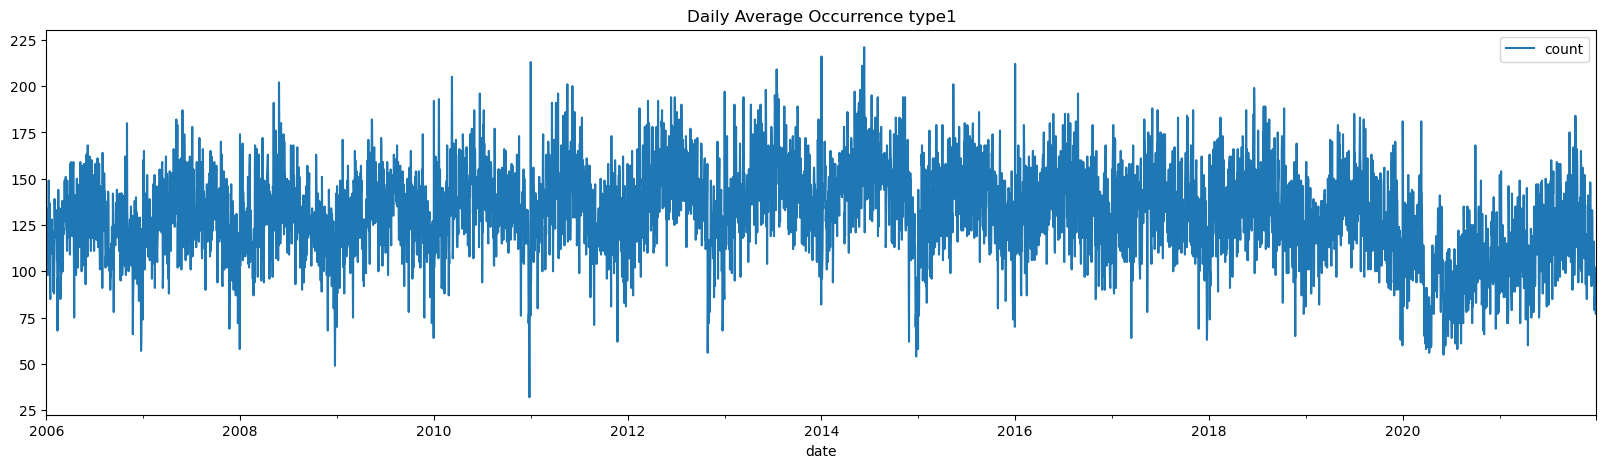

In [10]:
df_by_day.plot(figsize=fig_size, title="Daily Average Occurrence " + crime)
plt.show()

In [11]:
df_by_day[target].sort_values(ascending=False).head()

date
2014-06-11    221
2014-01-01    216
2011-01-01    213
2016-01-01    212
2014-06-04    211
Name: count, dtype: int64

### By week

In [12]:
df_by_week = pd.DataFrame(df_by_day[target].resample('W').mean())

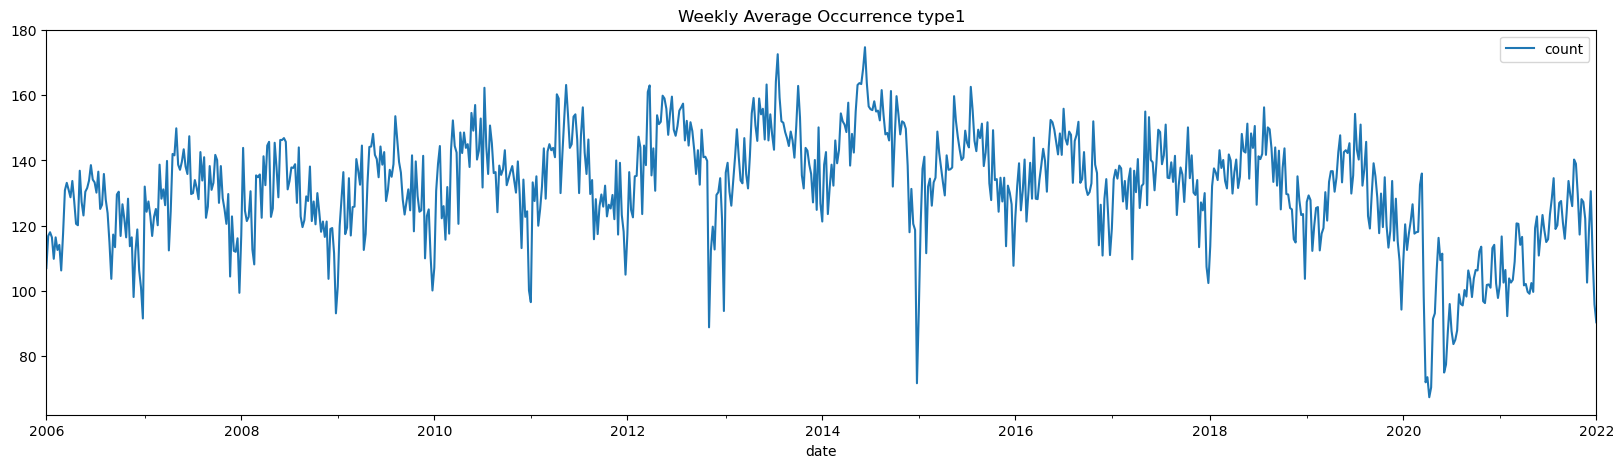

In [13]:
df_by_week.plot(
    figsize=fig_size,
    title="Weekly Average Occurrence " + crime)
plt.show()

### By month

In [14]:
df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())

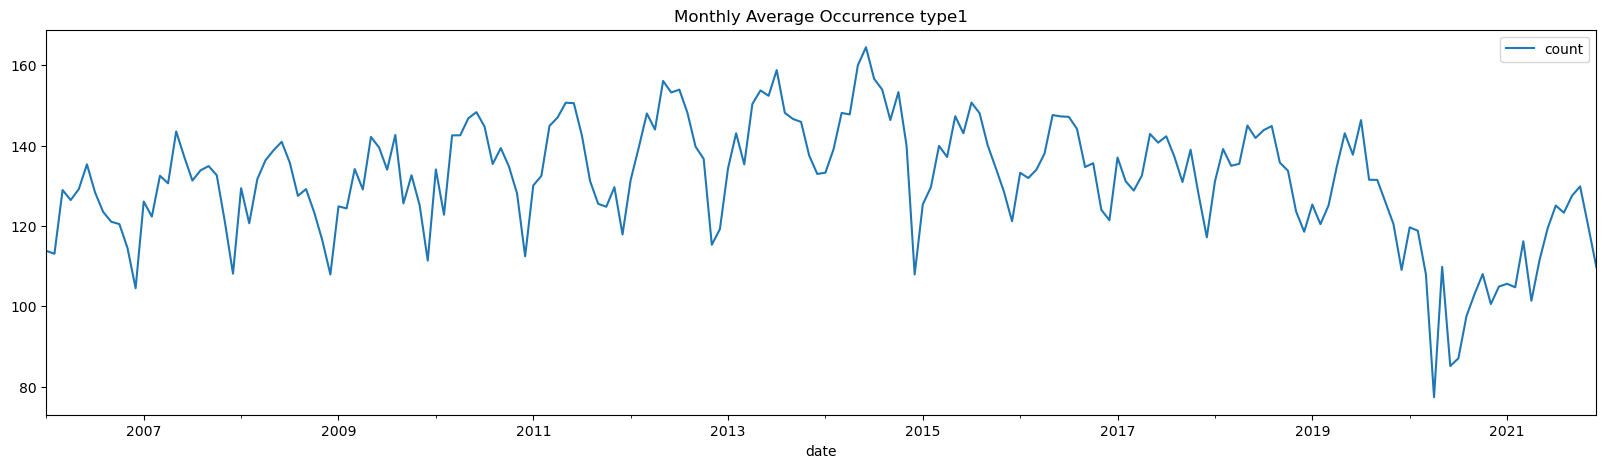

In [15]:
df_by_month.plot(
    figsize=fig_size, 
    title="Monthly Average Occurrence " + crime)
plt.show()

## Analysis

In [16]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Checking stationary

In [17]:
adfuller_test(df_by_month[target])

ADF Test Statistic : -1.8558505343444571
p-value : 0.3531067118505653
#Lags Used : 14
Number of Observations Used : 177
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Checking seasonality

In [18]:
df_by_month['seasonal_first_difference'] = df_by_month[target] - df_by_month[target].shift(12)

In [19]:
adfuller_test(df_by_month['seasonal_first_difference'].dropna())

ADF Test Statistic : -3.516023909094369
p-value : 0.007584977307881228
#Lags Used : 12
Number of Observations Used : 167
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: title={'center': 'Seasonal difference plot - type1'}, xlabel='date'>

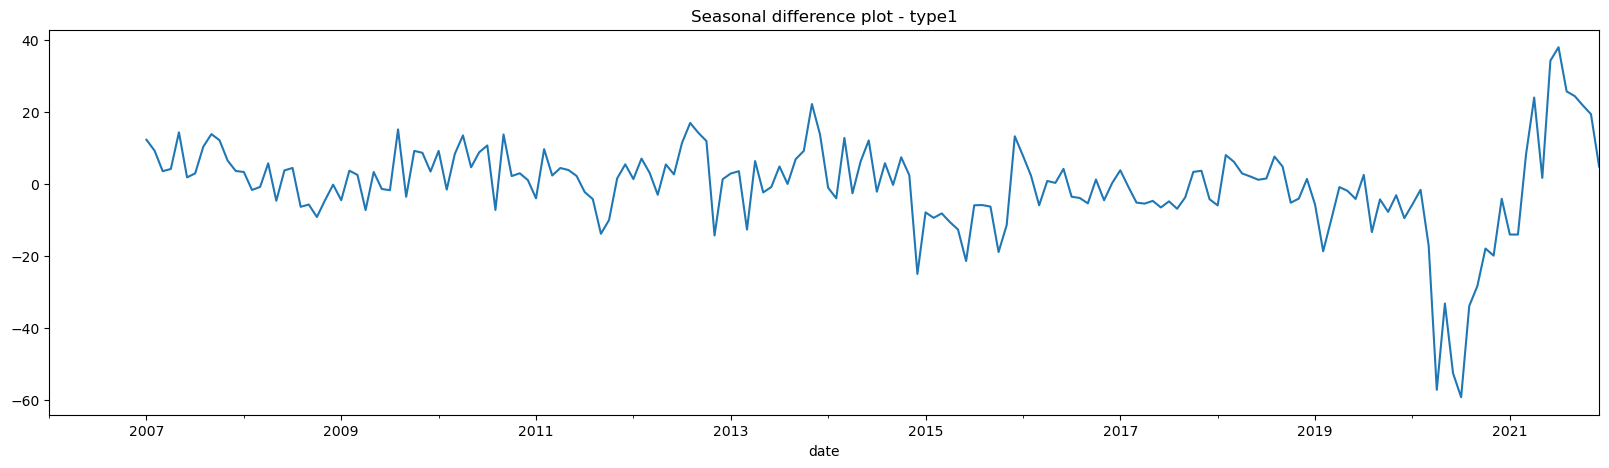

In [20]:
df_by_month['seasonal_first_difference'].plot(figsize=fig_size, title='Seasonal difference plot - ' + crime)

### Auto Regressive Model

/Users/xuyanchong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


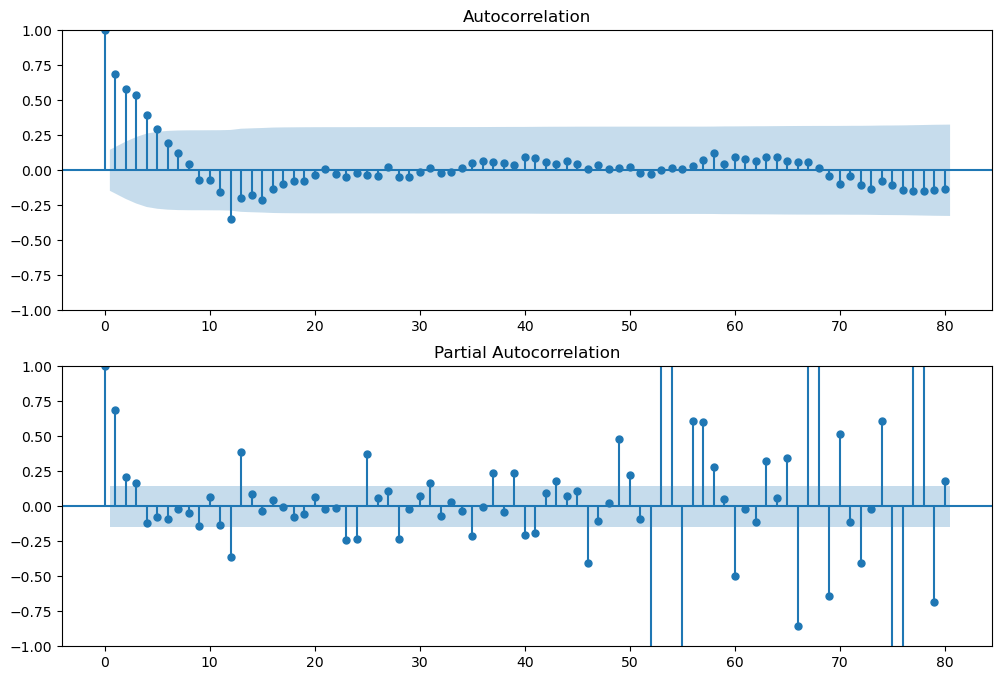

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax2)

### Implementing Seasonal Arima Model

In [22]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_by_month[target])

(0.01, False)

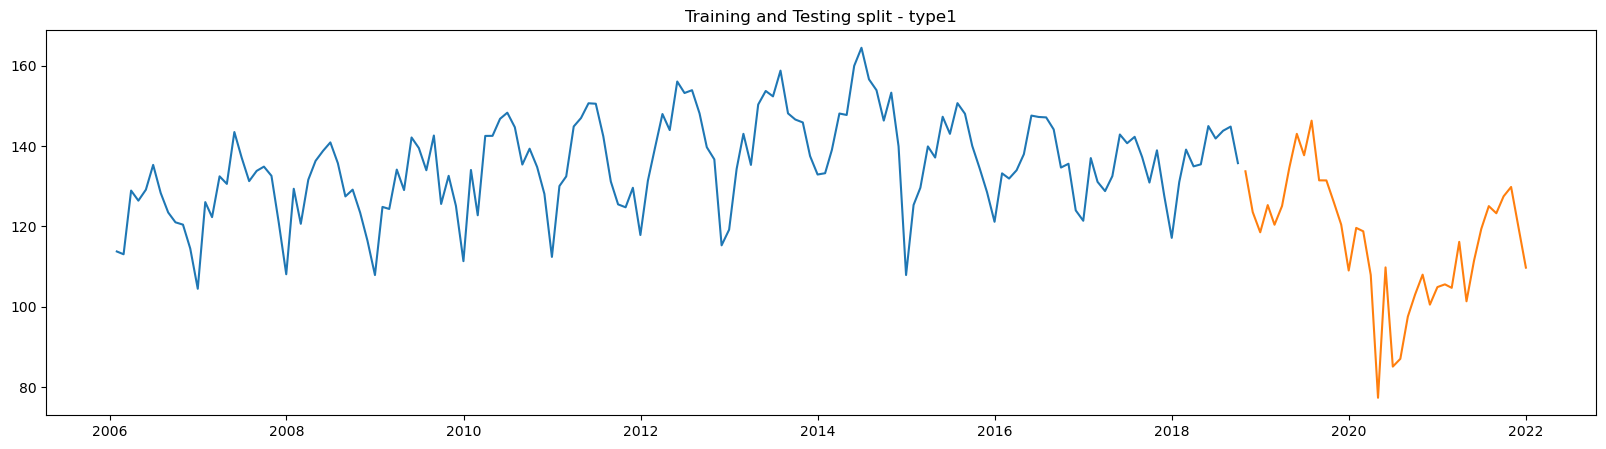

In [23]:
start=int(df_by_month.shape[0]*0.8)
train=df_by_month[:start]
test=df_by_month[start:]
plt.figure(figsize=fig_size)
plt.plot(train[target])
plt.plot(test[target])
plt.title('Training and Testing split - '+ crime)
plt.show()

In [24]:
model=auto_arima(train[target],start_p=0,d=1,start_q=0,
          max_p=10,max_d=10,max_q=10, start_P=0,
          D=1, start_Q=0, max_P=10,max_D=10,
          max_Q=10, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1001.756, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=939.636, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=895.705, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=956.026, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=897.560, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=897.538, Time=2.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=922.332, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=899.294, Time=8.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=928.833, Time=0.32 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=894.280, Time=0.93 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=956.773, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=895.795, Time=1.74 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=895.739, Time=21.69 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=920.270, Time=1.98 sec
 ARIMA(1,1,1)(1,1,2)[12]       

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  153
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -442.043
Date:                            Sun, 23 Apr 2023   AIC                            894.087
Time:                                    01:34:52   BIC                            908.795
Sample:                                01-31-2006   HQIC                           900.064
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0330      0.020     -1.658      0.097      -0.072       0.006
ar.L1          0.3398      0.095      3.586      0.000       0.154       0.526
ma.L1         -0.8941      0.056    -15.964      0.000      -1.004      -0.784
ma.S.L12      -0.8122      0.085     -9.562      0.000      -0.979      -0.646
sigma2        29.2120      3.730      7.831      0.000      21.901      36.523
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                20.56
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.59
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

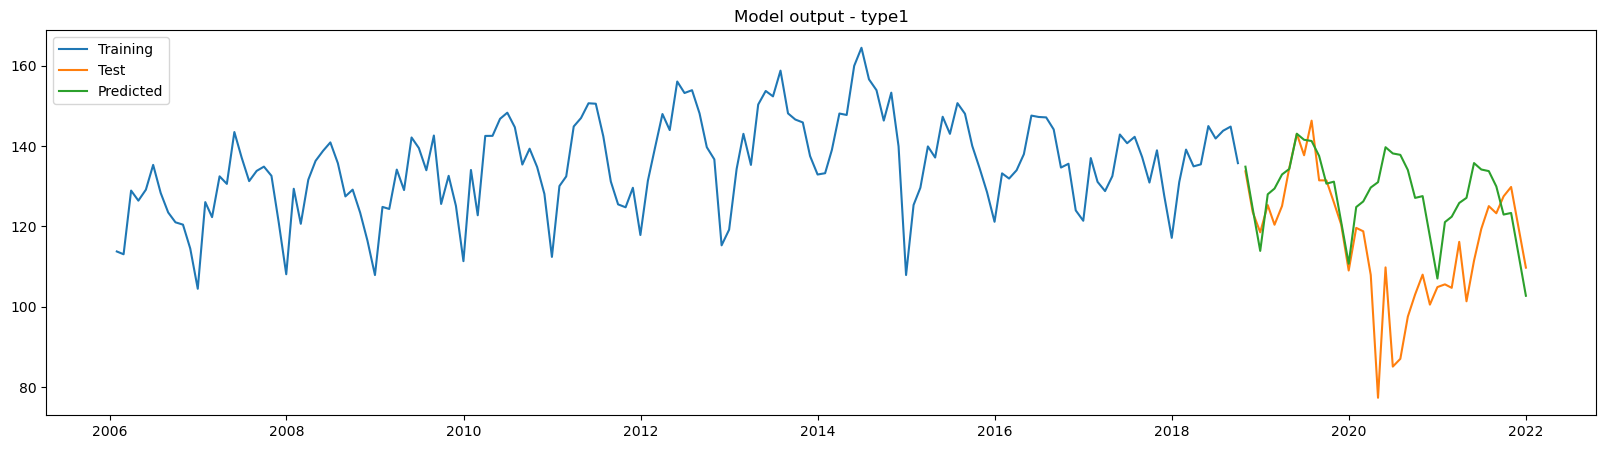

In [26]:
prediction = pd.DataFrame(model.predict(n_periods = train.shape[0]),index=test.index)
prediction.columns = ['predicted_crime']
plt.figure(figsize=fig_size)
plt.plot(train[target],label="Training")
plt.plot(test[target],label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('../output/%s_%s_pred.jpg' % (city,crime))
plt.title('Model output - '+crime)
plt.show()

In [27]:
np.sqrt(np.square(np.subtract(test[target].values,prediction['predicted_crime'].values)).mean())

19.612174106151354